<a href="https://colab.research.google.com/github/drpOpZ/RL_exam/blob/main/RL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Environment definition
import numpy as np

# map keying used for rewards and rendering (C Enum like)
key_road = 0
key_wall = 1
key_start = 2
key_finish = 3
key_cliff = 4
#TODO: sand? oil? checkpoint?

class Track():
  def __init__(self):

    self.basemap = self._generateBasemap()
    self.startpos = np.array(np.where(self.basemap == key_start)).transpose()
    self.walkable_mask = np.isin(self.basemap,[key_wall,key_cliff,key_finish],invert=True)

  def _generateBasemap(self):
    # fancy
    # basemap = np.full((20,20),key_road)
    # basemap[3,:] = key_wall;
    # basemap[3,2] = key_road;
    # basemap[6,6:17] = key_wall;
    # basemap[9,1:17] = key_wall;
    # basemap[13,7:] = key_wall;
    # basemap[16,:17] = key_wall;
    # basemap[16,2] = key_road;
    # basemap[4:17,3] = key_wall;
    # basemap[6:10,16] = key_wall;

    # basemap[18,(3,9,17)] = key_cliff;
    # basemap[1,-1] = key_start;
    # basemap[7,15] = key_finish;
    # return basemap

    # u-track
    basemap = np.full((10,7),key_road)
    basemap[:-3,3] = key_wall;
    basemap[9,:] = key_cliff;
    basemap[0,1] = key_start;
    basemap[0,-2] = key_finish;
    return basemap

# brutal computation of pixel ray
def computeRay(yx0,yx1):

  # trivial case
  if all(yx0==yx1):
    return np.array([yx0])

  # compute max box side and use it to set dy dx increments 
  ly,lx = yx1 - yx0
  max_box_side = max(abs(ly),abs(lx))
  dy,dx = ly/max_box_side, lx/max_box_side

  ray = []

  # coordinates falling in the middle of two tiles must mark both, considering direction 
  if abs(dx) == .5 or abs(dy) == .5:
    for iii in range(max_box_side+1):
      # no split
      if iii%2 == 0:
        ray.append((round(yx0[0]+iii*dy),round(yx0[1]+iii*dx)))
      # split vertically
      elif abs(dy) == .5:
        incr = dy/abs(dy)
        ray.append((round(yx0[0]+(iii-1)*dy),round(yx0[1]+iii*dx)))
        ray.append((round(yx0[0]+(iii-1)*dy + incr),round(yx0[1]+iii*dx)))
      # split horizontally
      else:
        incr = dx/abs(dx)
        ray.append((round(yx0[0]+iii*dy),round(yx0[1]+(iii-1)*dx)))
        ray.append((round(yx0[0]+iii*dy),round(yx0[1]+(iii-1)*dx + incr)))
  # o/w no splitting, just round
  else:
    for iii in range(max_box_side+1):
      ray.append((round(yx0[0]+iii*dy),round(yx0[1]+iii*dx)))

  return np.array(ray)

class GridPrixEnv():
  def __init__(self, track:Track, move_cost=-1, stop_cost=-2):
    self.track = track
    self.move_cost = move_cost
    self.stop_cost = stop_cost

    self.rewards={
        key_wall: -5,
        key_finish: 100,
        key_cliff: -5
    }
    self.palette={
      key_road : '░',
      key_wall : '█',
      key_start : 'S',
      key_finish : 'F',
      key_cliff : '!',
      "player": '☺'
    }
    self.reset()

  def reset(self):
    # NOTE: single starting point is picked
    self.state = (self.track.startpos[0], np.array([0,0]))
    self.episode_terminated = False

  # Computes an update from any given state without applying it
  # (s,a) ~> (s',r, finished)
  def computeStep(self,state,action):
    pos,speed = state
    episode_terminated = False

    # base move cost
    reward = self.move_cost
    
    # iteratively go through ray to compute final position and speed
    speed_new = speed + action
    pos_new = pos 
    for pos_temp in computeRay(pos,pos + speed_new)[1:,]:

      # outbounds or wall ~> stop and penalty
      if any(pos_temp < 0) or any(pos_temp >= self.track.basemap.shape) or self.track.basemap[tuple(pos_temp)]==key_wall:
        speed_new *= 0
        reward += self.rewards[key_wall]
        break

      # cliff ~> restart and penalty
      elif self.track.basemap[tuple(pos_temp)]==key_cliff:
        pos_new, speed_new = (self.track.startpos[0], np.array([0,0]))
        reward += self.rewards[key_cliff]
        break

      # effectively move of one position
      pos_new = pos_temp

      # finish ~> reward and termination
      if self.track.basemap[tuple(pos_temp)]==key_finish:
        reward = self.rewards[key_finish]
        episode_terminated = True
        break

    # didn't move ~> penalty
    if all(pos_new == pos):
      reward += self.stop_cost

    # pack
    state_new = (pos_new,speed_new)

    return state_new, reward, episode_terminated

  # actually applies action
  def step(self,action):
    self.state, reward, self.episode_terminated = self.computeStep(self.state,action)
    return self.state, reward, self.episode_terminated
  
  # Render environment with console graphics
  def render(self):
    x_size = self.track.basemap.shape[1]

    # top ruler
    print('yx',end=' ')
    for iii in range(x_size):
      if(iii%10==0):
        print(iii//10,end='')
      else:
        print(' ',end='')
    print('\n˅˃',end=' ')
    for iii in range(x_size):
      print(iii%10,end='')
    print()

    for yyy, lll in enumerate(self.track.basemap):

      # left ruler
      print('{:>2}'.format(yyy),end=' ')
      
      # pixels
      for xxx, ppp in enumerate(lll):
        if all(self.state[0] == (yyy,xxx)):
          print(self.palette["player"],end='')
        else:
          print(self.palette[ppp],end='')
      print()
    print("\nPosition (y,x):({} {})\nSpeed (y',x'):({} {})".format(self.state[0][0],self.state[0][1],self.state[1][0],self.state[1][1]))

In [ ]:
# Precomputes the actions available at each possible speed
class ActionsTable():
  def __init__(self,max_speed):
    
    self.max_speed = max_speed
    
    # possible actions: {-1,0,1}^2
    # NOTE: np.argwhere(np.ones((n,m))) = [[0,0] [0,1] ... [0,m] [1,0] ... [n,m]] ~ multi-index range()
    self.actions = np.argwhere(np.ones((3,3))) - 1

    # possible speeds: {-max_speed, ..., max_speed}^2    
    speeds_size = 2*max_speed+1
    self.inspeeds = np.argwhere(np.ones((speeds_size,speeds_size))) - self.max_speed

    # compute and store the boolean mask for each input speed
    self.masks = np.full((speeds_size,speeds_size,9),False)
    for ij in np.argwhere(np.ones((speeds_size,speeds_size))):
      # (0,0)...(2n,2n) ~> (-n,-n)...(n,n) 
      inspeed = ij - self.max_speed
      
      # 'shift' actions by inspeed, abs, set true where both shifted components are <= max_speed
      self.masks[tuple(ij)] = np.all(np.abs(self.actions + inspeed) <= self.max_speed, axis=-1)

  # Retrieves the available actions as a (<=9,2) array
  def __call__(self,input_speed):
    ij = tuple(input_speed + self.max_speed)
    return self.actions[self.masks[ij]]

# Computes the index of an action as of ActionTable.actions
# array (2,) -> int
def act2Index(action):
  return sum((action + 1)*(3,1)) 

In [ ]:
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt

class RLAgent():
  def __init__(self, max_speed, train_env:GridPrixEnv):
    
    self.max_speed = max_speed
    self.actions_table = ActionsTable(self.max_speed)

    self.train_env = train_env
    
    # compute state space shape (4-d array (ypos,xpos,yspeed,xspeed))
    inspeeds_size = 2*self.max_speed+1
    self.states_shape = (*self.train_env.track.basemap.shape, inspeeds_size, inspeeds_size)

    # compute random policy (ie uniform distribution over valid actions)
    self.random_policy = np.zeros((*self.states_shape,9))
    self.random_policy[:,:] = self.actions_table.masks / np.sum(self.actions_table.masks,2)[:,:,np.newaxis]

    self.resetPolicy()
  
  # sets policy to uniform over valid actions
  def resetPolicy(self):
    self.policy = np.copy(self.random_policy)

  # picks an action from given state accordingly to current or random policy ("epsilon-policy")
  def pickAction(self, exploration_rate = 0, state=None):
    # if no state is given current one is used
    if state is None:
      state = self.train_env.state

    pos,speed = state
    speed = speed + self.max_speed
    
    # extract probabilities from appropriate policy
    if exploration_rate>0 and np.random.binomial(1,exploration_rate):
      probs = self.random_policy[(*pos,*speed)]
    else:
      probs = self.policy[(*pos,*speed)]
    
    idx_action = np.random.choice(9,p=probs)
    return self.actions_table.actions[idx_action]

  # Ride the training track using current policy and return score and no. moves
  def runOnTrainEnv(self, max_moves= 20, render = True, renderDelay=0):
    self.train_env.reset()
    if render:
      self.train_env.render()
    
    update_count = 0
    terminated = False
    score = 0
    while not terminated and update_count < max_moves:
      action = self.pickAction()
      _, reward, terminated = self.train_env.step(action)
      score += reward
      if render:
        print('action: {}'.format(action))
        if renderDelay>0:
          os.system('sleep {}'.format(renderDelay))
          clear_output(True)
        self.train_env.render()
        print('score: {}'.format(score))
      update_count += 1

    if render:
      print('FINAL SCORE: {}\nTotal moves: {}'.format(score,update_count))
    
    return score, update_count
  
  def renderPolicy(self):
    pass


In [ ]:
class AgentPlanner(RLAgent):
  def __init__(self, max_speed, train_env:GridPrixEnv):
    
    super().__init__(max_speed, train_env)
    
    # starting values: 0 where reachble, -infty elsewhere.
    self.values = np.zeros(self.states_shape)
    self.values[self.train_env.track.walkable_mask == False] = -np.inf

    # Finish must be handleded separately, as it's reachable though we don't want to update it
    self.values[self.train_env.track.basemap == key_finish] = 0


  # Performs the value iteration step 
  def value_iteration_step(self, discount_factor):

    # initialize arrays for new values and policy 
    values_new = np.full(self.states_shape,-np.inf)
    values_new[self.train_env.track.basemap == key_finish] = 0

    policy_new = np.copy(self.policy)

    # compute values and update policy at valid positions (i.e. walkable tiles) for all possible speeds
    for pos in np.argwhere(self.train_env.track.walkable_mask):
      for speed in self.actions_table.inspeeds:
        # deduce state index for value array from position and speed
        state_idx = (*pos,*(speed + self.actions_table.max_speed))

        # compute value for ALL (valid!) ACTIONS from current state
        action_scores = np.full(9,-np.inf)
        for action in self.actions_table(speed):

          # Use model to obtain reward and landing state WITHOUT APPLYING CHANGE
          state_new, reward, _ = self.train_env.computeStep((pos,speed),action)

          # Compute and store action value in action_scores at appropriate index
          state_new_idx = (*state_new[0],*(state_new[1] + self.max_speed))
          act_index = act2Index(action)
          action_scores[act_index] = reward + discount_factor * self.values[state_new_idx]
          
        # set new value to max
        value_best = np.max(action_scores)
        values_new[state_idx] = value_best

        # set policy to uniform distribution over actions with max value
        actions_flags = np.array(action_scores == value_best, dtype=float)
        policy_new[state_idx] = actions_flags/sum(actions_flags)

    return values_new, policy_new


  # Learns the optimal policy through VI with given parameters
  def train(self, discount_factor = .9, threshold = .01, max_steps = np.inf):

    # repeat VI step until termination
    error = np.inf
    iii=0
    while error > threshold and iii < max_steps:
      
      values_new, policy_new = self.value_iteration_step(discount_factor)
      
      # error = infinity norm between subsequent values matrices
      error = np.max(np.abs(self.values[self.train_env.track.walkable_mask] - values_new[self.train_env.track.walkable_mask]))

      # update values and policy
      self.values, self.policy = values_new, policy_new
      
      print('step {} error: {}'.format(iii,error))
      iii += 1

    print('Done!')


In [ ]:
a = AgentPlanner(2,GridPrixEnv(Track()))
# renderPolicy(a)

In [ ]:
a.train(threshold=100)

step 0 error: 90.0
Done!


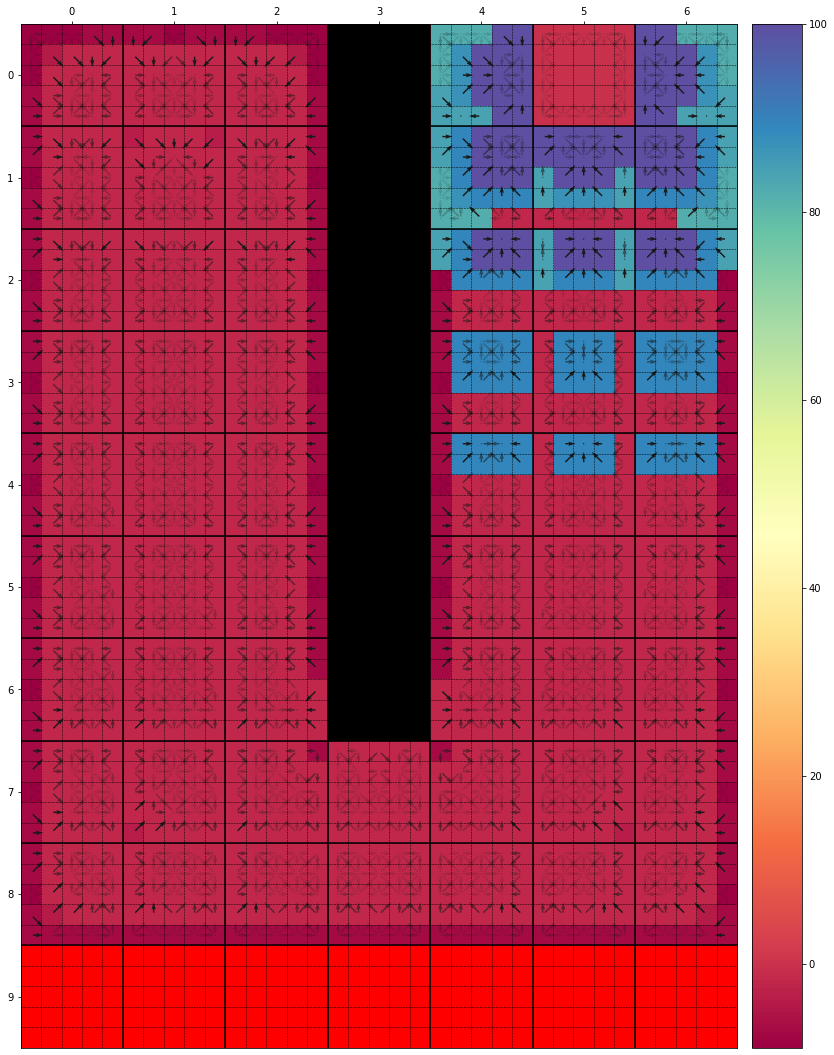

In [ ]:
renderPolicy(a)

In [ ]:
def valuesTo2d(values):
  size_y,size_x,speeds_size,_ = values.shape
  out = np.empty((size_y*speeds_size,size_x*speeds_size))
  for iy,ix in np.argwhere(np.ones((size_y,size_x))):
    out[iy*speeds_size:(iy+1)*speeds_size,ix*speeds_size:(ix+1)*speeds_size] = values[iy,ix]
  return out

def policyToQuiverParameters(policy):
  v,u = [(x-1) for x in np.where(np.ones((3,3)))]

  speeds_size = policy.shape[3]
  X = np.empty_like(policy)
  Y = np.empty_like(policy)
  U = np.empty_like(policy)
  V = np.empty_like(policy)
  for py,px,vy,vx in np.argwhere(np.ones(policy.shape[:-1])):
    X[py,px,vy,vx] = px*speeds_size + vx
    Y[py,px,vy,vx] = py*speeds_size + vy
  U[:,:,:,:] = u
  V[:,:,:,:] = v
  X+= U*.1
  Y+= V*.1
  C= np.copy(policy)

  return X.flatten(),Y.flatten(),U.flatten(),V.flatten(),C.flatten()

def checkers(ss):
  return np.arange(ss**2).reshape((ss,ss))%2

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def renderPolicy(self:RLAgent,values):
  # Ly, Lx = World.shape

  # prepare data for plotting
  vsize_y, vsize_x, speeds_size = self.policy.shape[:-2]
  img_data = valuesTo2d(values)
  img_data[img_data==-np.inf] = 0

  # setup figure and basic value bg
  fig, ax = plt.subplots(figsize=(vsize_x*2,vsize_y*2))
  im = ax.imshow(img_data, cmap=plt.get_cmap("Spectral"))

  # store image limits, so that later we can restore them
  xb = ax.get_xlim()
  yb = ax.get_ylim()

  # policy arrows
  alphalevs = 7
  alphamap = ListedColormap(np.column_stack((np.full((alphalevs,3),.1),np.linspace(0,1,alphalevs))))
  
  ax.quiver(*policyToQuiverParameters(self.policy),
            scale_units='xy',scale=2,angles='xy', width=.002,cmap=alphamap)

  # side color scale
  ax_divider = make_axes_locatable(ax)
  cscale = ax_divider.append_axes("right", size="7%", pad="2%")
  cbar = fig.colorbar(im, cax=cscale)

  # manual grid
  ax.hlines(np.arange(1,vsize_y*speeds_size) -.5,*xb, lw=.5,ls='--')
  ax.vlines(np.arange(1,vsize_x*speeds_size) -.5,*yb, lw=.5,ls='--')
  ax.hlines(np.arange(1,vsize_y)*speeds_size -.5,*xb)
  ax.vlines(np.arange(1,vsize_x)*speeds_size -.5,*yb)

  # set ticks
  ax.set_yticks(np.arange(vsize_y)*speeds_size + speeds_size//2)
  ax.set_yticklabels(np.arange(vsize_y))
  ax.xaxis.set_ticks_position('top')
  ax.set_xticks(np.arange(vsize_x)*speeds_size + speeds_size//2)
  ax.set_xticklabels(np.arange(vsize_x))

  # mask walls and cliffs
  ax.add_collection(PatchCollection(
      [Rectangle((x,y),speeds_size,speeds_size) for y,x in (np.argwhere(self.train_env.track.basemap == key_wall)*speeds_size - .5)],
      facecolor='#000000',zorder=2))
  ax.add_collection(PatchCollection(
      [Rectangle((x,y),speeds_size,speeds_size) for y,x in (np.argwhere(self.train_env.track.basemap == key_cliff)*speeds_size - .5)],
      facecolor='#ff0000',zorder=2))
  
  # start
  ax.add_collection(PatchCollection(
      [Rectangle((x,y),speeds_size,speeds_size) for y,x in (np.argwhere(self.train_env.track.basemap == key_start)*speeds_size - .5)],
      lw=5,facecolor='#00000000',edgecolor='#00ff00',zorder=2))
  
  # finish
  ax.add_collection(PatchCollection(
      [Rectangle((x,y),speeds_size,speeds_size) for y,x in (np.argwhere(self.train_env.track.basemap == key_finish)*speeds_size - .5)],
      facecolor='#ffffff',zorder=2))
  for pos in (np.argwhere(self.train_env.track.basemap == key_finish)*speeds_size - .5):
    ax.add_collection(PatchCollection(
        [Rectangle((x,y),1,1) for y,x in np.argwhere(checkers(speeds_size))+pos],
        facecolor='#000000',zorder=2))

  # restore limits (bounds o/w image flips)
  ax.set_xbound(*xb)
  ax.set_ybound(*yb)

  plt.show()

step 0 error: 0.0
Done!


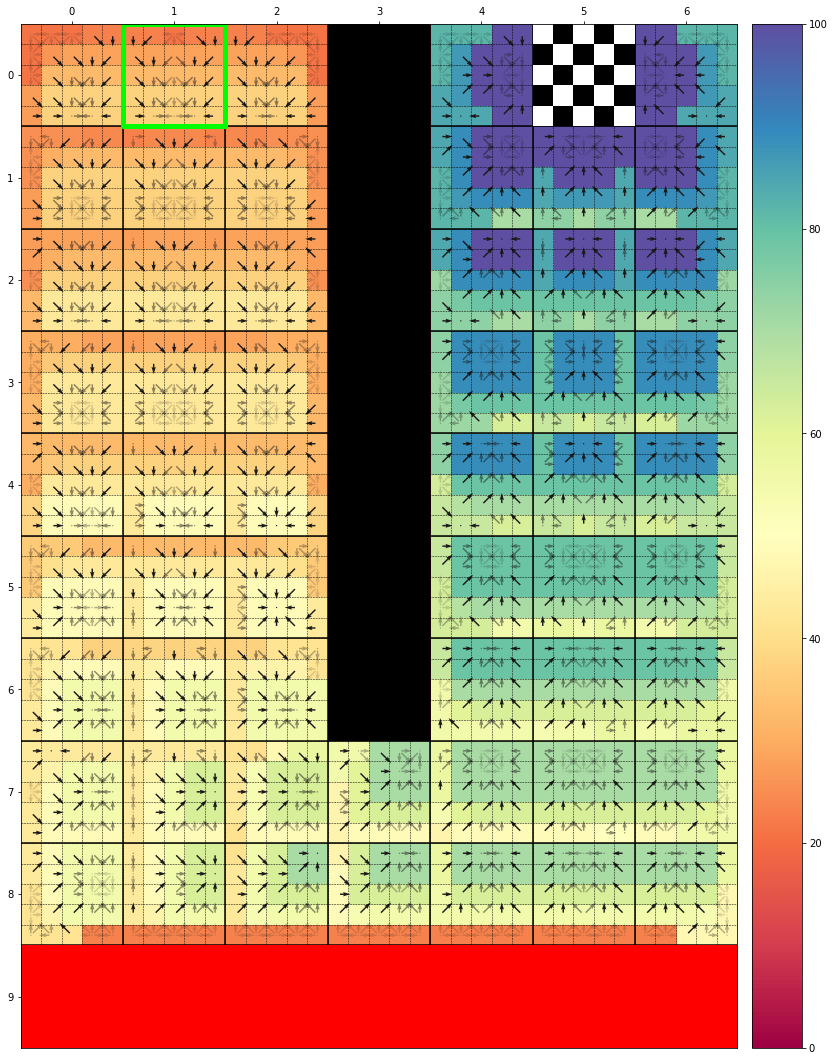

In [ ]:
a.train()
renderPolicy(a,a.values)

In [ ]:
_ = a.runOnTrainEnv(renderDelay=1)

yx 0      
˅˃ 0123456
 0 ░S░█░☺░
 1 ░░░█░░░
 2 ░░░█░░░
 3 ░░░█░░░
 4 ░░░█░░░
 5 ░░░█░░░
 6 ░░░█░░░
 7 ░░░░░░░
 8 ░░░░░░░
 9 !!!!!!!

Position (y,x):(0 5)
Speed (y',x'):(-3 -1)
score: 91
FINAL SCORE: 91
Total moves: 10


$$\varepsilon(t) = \begin{cases}
\bar\varepsilon & t<\bar t\\
\frac{\bar\varepsilon}{1+k(t-\bar t)^e} &t\geq \bar t
\end{cases}$$

In [ ]:
class Scheduler():
  def __init__(self, base_value, decay_start, decay_rate, decay_exp):
      self.base_value = base_value
      self.decay_start = decay_start
      self.decay_rate = decay_rate
      self.decay_exp = decay_exp
  
  def __call__(self,tstep):
    if tstep < self.decay_start:
      return self.base_value
    else:
      return self.base_value / (1 + self.decay_rate * np.power((tstep - self.decay_start),self.decay_exp))

In [ ]:
tdtype_sarsa = 0
tdtype_ql = 1
tdtype_esarsa =2

class AgentModelFree(RLAgent):
  def __init__(self, max_speed, train_env:GridPrixEnv, tdtype, memory_factor, memory_cutoff):
    
    super().__init__(max_speed, train_env)
    
    # starting qvalues: 0 where reachable, -infty elsewhere
    self.qvalues = np.zeros(self.policy.shape)
    self.qvalues[self.train_env.track.walkable_mask == False] = -np.inf
    self.qvalues[self.random_policy==0] = -np.inf
    self.qvalues[self.train_env.track.basemap == key_finish] = 0

    self.tdtype = tdtype

    # initialize elegibility trace if needed
    self.memory_factor = memory_factor
    self.memory_cutoff = memory_cutoff
    self.resetElegibilityTrace()

  def resetElegibilityTrace(self):
    if self.memory_factor > 0:
      self.elegibily_trace = np.zeros(self.policy.shape)

  def td_step(self, learning_rate, exploration_rate, discount_factor):
    
    # Pick and execute action to get s' and reward
    state = self.train_env.state
    action = self.pickAction(exploration_rate)
    stac_idx = (*state[0],*(state[1]+self.max_speed),act2Index(action))
    
    state_new, reward, _ = self.train_env.step(action)    


    # compute deltaqv 
    # SARSA
    if self.tdtype == tdtype_sarsa:
      # pick a' (current policy = eps-greedy) 
      action_new = self.pickAction(exploration_rate)
      stac_new_idx = (*state_new[0],*(state_new[1]+self.max_speed),act2Index(action_new))
      
      # dq(s,a) = r + discount_factor * q(s',a') - q(s,a)
      deltaqv = reward + discount_factor * self.qvalues[stac_new_idx] - self.qvalues[stac_idx]
    
    # Q-Learning 
    elif self.tdtype == tdtype_ql:

      state_new_idx = (*state_new[0],*(state_new[1]+self.max_speed))
      
      # pick a' (greedy)
      action_scores = self.qvalues[state_new_idx]
      actions_flags = np.array(action_scores == np.max(action_scores), dtype=float)
      probs = actions_flags/np.sum(actions_flags)
      action_best_idx = np.random.choice(9,p=probs)

      stac_best_idx = (*state_new_idx,action_best_idx)

      # dq(s,a) = r + discount_factor * max(q(s',:)) - q(s,a)
      deltaqv = reward + discount_factor * self.qvalues[stac_best_idx] - self.qvalues[stac_idx]

    # Expected SARSA
    else:
      # compute average qvalues of possible next actions over (greedy) policy
      state_new_idx = (*state_new[0],*(state_new[1]+self.max_speed))
      valid_mask = self.policy[state_new_idx] > 0
      avg_qvalue = np.dot(self.qvalues[state_new_idx][valid_mask] , self.policy[state_new_idx][valid_mask])

      # dq(s,a) = r + discount_factor * avg(q(s',:)| a'~policy) - q(s,a)
      deltaqv = reward + discount_factor * avg_qvalue - self.qvalues[stac_idx]
    

    # update qvalues and policy
    # Using elegibility trace ~> multiple updates
    if self.memory_factor>0:
      
      # 'forget' the past and refresh latest (s,a)
      self.elegibily_trace *= self.memory_factor 
      self.elegibily_trace *= np.array(self.elegibily_trace > self.memory_cutoff,dtype=float)
      self.elegibily_trace[stac_idx] = 1 

      # update qvalues
      self.qvalues += (learning_rate * deltaqv * self.elegibily_trace)
      
      # update policy where required (greedy)
      # 4-D bool mask of states requiring update (= S such that et[S,A] >0 )
      states_mask = np.sum(self.elegibily_trace>0, axis=-1)>0
      # 1-D array of max qvalues on given mask
      qvalues_best = np.max(self.qvalues[states_mask],axis=-1)
      # 2-D binary array marking actions corresponding to max qvalue at masked state
      policy_flags = np.array(self.qvalues[states_mask] == (qvalues_best[:,np.newaxis]),dtype=float)
      # compute probabilities from flags and update policy
      self.policy[states_mask] = policy_flags / (np.sum(policy_flags, axis=-1)[:,np.newaxis])
    
    # no elegibility trace ~> only update [s,a]
    else:
      # update qvalue[s,a]
      self.qvalues[stac_idx] += (learning_rate * deltaqv)

      # update policy[s,a] (greedy)
      qvalue_best = np.max(self.qvalues[stac_idx[:-1]])
      policy_flags = np.array(self.qvalues[stac_idx[:-1]] == qvalue_best, dtype=float)
      self.policy[stac_idx[:-1]] = policy_flags / np.sum(policy_flags)
  
    return state_new, reward
 
  # Attempts to learn the optimal policy through TD-learning with given parameters
  def train(self, n_episodes, max_steps, lr_sched:Scheduler, er_sched:Scheduler, discount_factor = .9, episode_perf_metric = None, verbose=10):
    
    n_steps = []
    scores = []
    metrics = []
    metric = '-'

    if verbose:
      print('{:>10}: {:>10} {:>10} {:>10} {}'.format('Episode n.', 'Steps', 'Score', 'Metric', 'Finished?'))

    for ep in range(n_episodes):
      self.resetElegibilityTrace()
      self.train_env.reset()

      tstep = 0
      ep_score = 0
      while tstep < max_steps and not self.train_env.episode_terminated:
        _ , reward = self.td_step(lr_sched(tstep),er_sched(tstep),discount_factor)
        ep_score += reward
        tstep += 1
      
      n_steps.append(tstep)
      scores.append(ep_score)
      if episode_perf_metric:
        metric = episode_perf_metric(self)
        metrics.append(metric)
        
      if verbose>0 and ep % verbose == 0:
        print('{:>10}: {:>10} {:>10} {:>10} {}'.format(ep, tstep, ep_score, metric, self.train_env.episode_terminated))
    
    if verbose:
      print('{:>10}: {:>10} {:>10} {:>10} {}'.format(ep, tstep, ep_score, metric, self.train_env.episode_terminated))
      print('Done!')
    
    return n_steps, scores, metrics
  
  def computeValue(self):
    q0 = np.copy(self.qvalues)
    q0[self.qvalues==-np.inf] = 0
    return np.sum(q0 * self.policy, -1)

In [ ]:
class MSEMetric():
  def __init__(self,reference,mask):
    self.reference = reference
    self.mask = mask
  def __call__(self,agent:AgentModelFree):
    return np.mean(np.square(agent.policy[self.mask]-self.reference[self.mask]))

class RoadChallengeMetric():
  def __init__(self,opponent:RLAgent,runs=1,max_moves=np.inf):
    self.opponent = opponent
    self.runs = runs
    self.max_moves = max_moves
  def __call__(self,agent:RLAgent):
    
    scores_agent = []
    scores_opponent = []

    for iii in range(self.runs):
      score_agent,_ = agent.runOnTrainEnv(self.max_moves,False)
      score_opponent,_ = self.opponent.runOnTrainEnv(self.max_moves,False)
      scores_agent.append(score_agent)
      scores_opponent.append(score_opponent)
    
    return np.mean(scores_agent) - np.mean(scores_opponent)

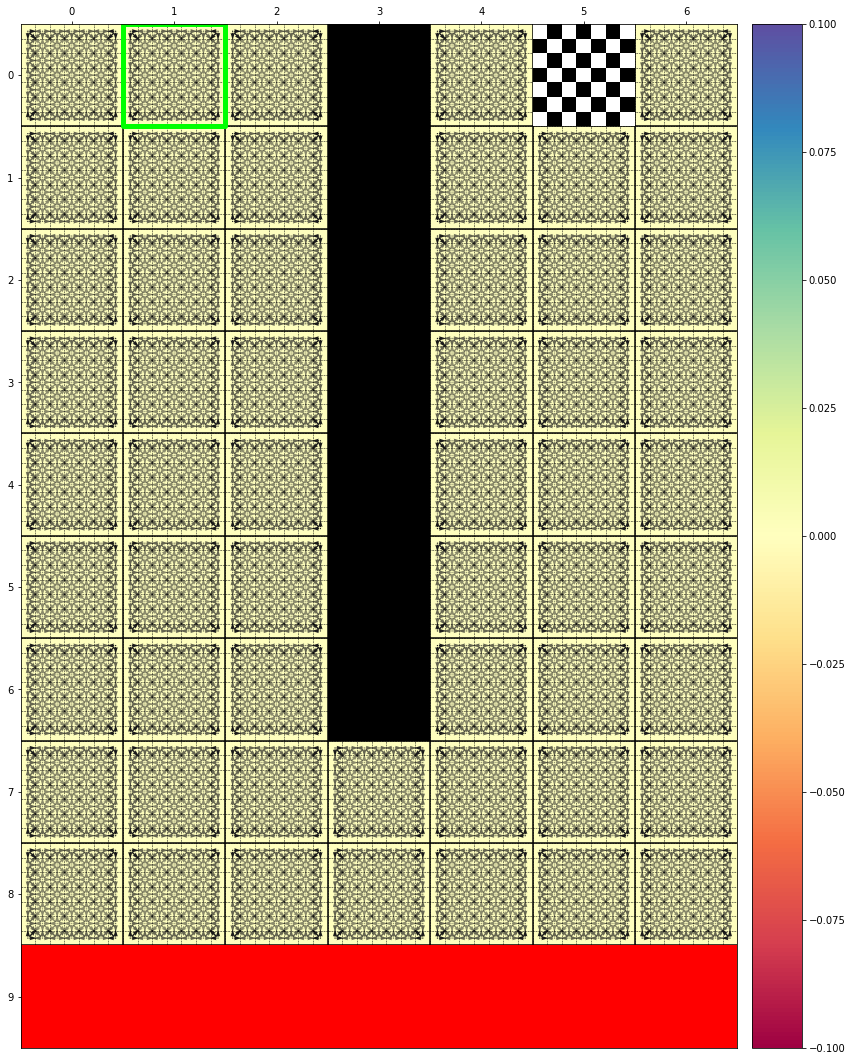

In [ ]:
b = AgentModelFree(3,GridPrixEnv(Track()),tdtype_ql,0,.4)
renderPolicy(b,b.computeValue())

In [ ]:
lr_sched = Scheduler(.9,150,1,1)
er_sched = Scheduler(.8,50,1,1)
msem = MSEMetric(a.policy,b.train_env.track.walkable_mask)
rcm = RoadChallengeMetric(a,10,50)

Episode n.:      Steps      Score     Metric Finished?
         0:         63        -51        0.0 True
       100:         22         44        0.0 True
       200:         62        -83        0.0 True
       300:         51        -50        0.0 True
       400:         62        -82        0.0 True
       500:         59        -84        0.0 True
       600:         58        -96        0.0 True
       700:         60        -58        0.0 True
       800:         61        -72        0.0 True
       900:         38        -20        0.0 True
       999:         56        -36        0.0 True
Done!


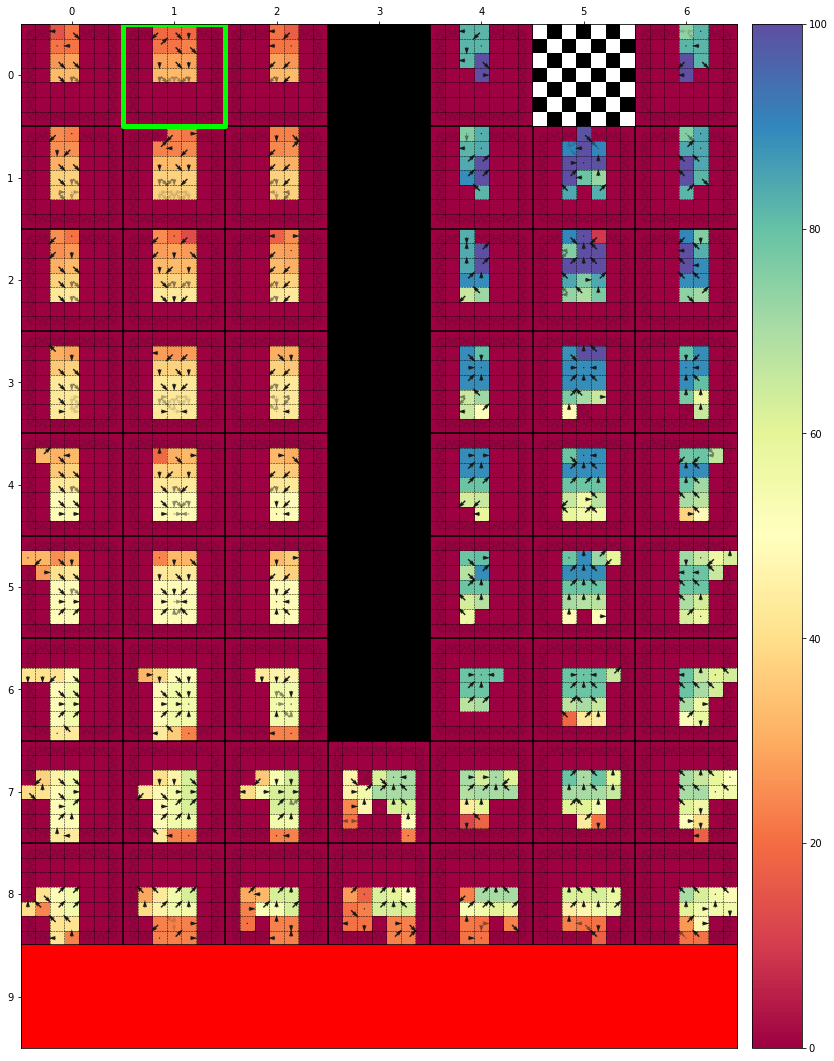

In [ ]:
_ = b.train(1000,200,lr_sched,er_sched,episode_perf_metric=rcm,verbose=100)
renderPolicy(b,b.computeValue())